In [1]:
!pip install pandas_ta yfinance


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import joblib
import matplotlib.pyplot as plt
import pandas_ta as ta


In [5]:
# --- Custom Transformer Encoder Layer (Correct and Final Version) ---
@tf.keras.utils.register_keras_serializable()
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(self.ff_dim, activation="relu"),
            Dense(self.embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(self.rate)
        self.dropout2 = Dropout(self.rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + self.dropout2(ffn_output))
        return out2

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

# --- Positional Encoding Function ---
def get_positional_encoding(sequence_length, d_model):
    positions = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((1, sequence_length, d_model))
    pos_enc[0, :, 0::2] = np.sin(positions * div_term)
    if d_model % 2 != 0:
        pos_enc[0, :, 1::2] = np.cos(positions * div_term)[:,:-1]
    else:
        pos_enc[0, :, 1::2] = np.cos(positions * div_term)
    return tf.cast(pos_enc, dtype=tf.float32)

print("Cell 1 executed: Setup and definitions are ready.")


Cell 1 executed: Setup and definitions are ready.


In [9]:
# ==============================================================================
# CELL 2 (NEW AND IMPROVED): PREPARE, TRAIN, AND SAVE EVERYTHING
# This single, robust cell handles all critical steps to ensure the model
# and the scaler are always perfectly synchronized.
# ==============================================================================
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



try:
    # --- PART 1: DATA PREPARATION (Integrated from Cell 1) ---
    print("--- 1. Downloading and Preparing Data ---")
    TICKER = "AAPL"
    START_DATE = "2020-01-01"
    END_DATE = "2025-01-01"

    price_data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)

    if isinstance(price_data.columns, pd.MultiIndex):
        price_data.columns = [col[0].lower() for col in price_data.columns]
    else:
        price_data.columns = price_data.columns.str.lower()

    price_data.ta.rsi(append=True)
    price_data.ta.macd(append=True)
    price_data.dropna(inplace=True)
    price_data.reset_index(inplace=True)

# Use the EXACT column names created by pandas_ta
    feature_columns = ['close', 'high', 'low', 'open', 'volume', 'RSI_14', 'MACD_12_26_9']
    target_column = 'close'
    price_data_final = price_data[feature_columns]

    print("--- 2. Scaling Features ---")
    # The scaler is created here, ensuring it matches the data being used for training.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(price_data_final)

    print("--- 3. Creating Sequences ---")
    sequence_length = 60
    X, y = [], []
    close_price_index = feature_columns.index(target_column)
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, :])
        y.append(scaled_data[i, close_price_index])
    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    print(f"Data ready for training. X_train shape: {X_train.shape}")

    # --- PART 2: MODEL DEFINITION AND TRAINING (Your structure + improvements) ---
    print("\n--- 4. Defining & Building Transformer Model ---")

    @tf.keras.utils.register_keras_serializable()
    class TransformerEncoder(tf.keras.layers.Layer):
        def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
            super(TransformerEncoder, self).__init__(**kwargs)
            self.embed_dim, self.num_heads, self.ff_dim, self.rate = embed_dim, num_heads, ff_dim, rate
        def build(self, input_shape):
            self.att = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
            self.ffn = tf.keras.Sequential([Dense(self.ff_dim, activation="relu"), Dense(self.embed_dim)])
            self.layernorm1, self.layernorm2 = LayerNormalization(epsilon=1e-6), LayerNormalization(epsilon=1e-6)
            self.dropout1, self.dropout2 = Dropout(self.rate), Dropout(self.rate)
            super(TransformerEncoder, self).build(input_shape)
        def call(self, inputs):
            attn_output = self.att(inputs, inputs)
            out1 = self.layernorm1(inputs + self.dropout1(attn_output))
            ffn_output = self.ffn(out1)
            out2 = self.layernorm2(out1 + self.dropout2(ffn_output))
            return out2
        def get_config(self):
            config = super(TransformerEncoder, self).get_config()
            config.update({"embed_dim": self.embed_dim, "num_heads": self.num_heads, "ff_dim": self.ff_dim, "rate": self.rate})
            return config

    def get_positional_encoding(sequence_length, d_model):
        positions = np.arange(sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pos_enc = np.zeros((1, sequence_length, d_model))
        pos_enc[0, :, 0::2] = np.sin(positions * div_term)
        pos_enc[0, :, 1::2] = np.cos(positions * div_term)[:,:pos_enc[0,:,1::2].shape[1]]
        return tf.cast(pos_enc, dtype=tf.float32)

    num_features = X_train.shape[2]
    embed_dim = num_features
    num_heads = 4
    ff_dim = 32

    inputs = Input(shape=(sequence_length, num_features))
    positional_encoding = get_positional_encoding(sequence_length, embed_dim)
    x = inputs + positional_encoding
    transformer_block = TransformerEncoder(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    # --- Compile and Train (using your EarlyStopping) ---
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    print("\n--- 5. Starting Model Training ---")
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # --- PART 3: SAVE EVERYTHING TOGETHER (The most important step) ---
    print("\n--- 6. Saving Model, Scaler, and Test Data ---")
    model.save('stock_prediction_transformer.keras')
    print("Model saved to 'stock_prediction_transformer.keras'")

    # This is the critical line: save the scaler that was created and used in THIS cell.
    joblib.dump(scaler, 'data_scaler.pkl')
    print("Scaler saved to 'data_scaler.pkl'")

    np.save('X_test.npy', X_test)
    np.save('y_test.npy', y_test)
    print("Test data saved for evaluation.")

    print("\nCELL FINISHED SUCCESSFULLY. All artifacts are now synchronized.")

except Exception as e:
    print(f"\nAN ERROR OCCURRED: {e}")
    # This helps in debugging by printing the full error traceback
    import traceback
    traceback.print_exc()




--- 1. Downloading and Preparing Data ---
--- 2. Scaling Features ---
--- 3. Creating Sequences ---
Data ready for training. X_train shape: (932, 60, 7)

--- 4. Defining & Building Transformer Model ---


/tmp/ipython-input-737157425.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 60, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 60, 7)          │         1,390 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 7)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,571 (6.14 KB)

 Trainable params: 1,571 (6.14 KB)

 Non-trainable params: 0 (0.00 B)


--- 5. Starting Model Training ---
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2790 - mae: 0.4369 - val_loss: 0.1071 - val_mae: 0.3139
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0746 - mae: 0.2035 - val_loss: 0.1160 - val_mae: 0.3249
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0519 - mae: 0.1737 - val_loss: 0.1092 - val_mae: 0.3114
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0290 - mae: 0.1305 - val_loss: 0.0666 - val_mae: 0.2404
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0253 - mae: 0.1211 - val_loss: 0.0368 - val_mae: 0.1752
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0180 - mae: 0.0977 - val_loss: 0.0249 - val_mae: 0.1436
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146 - mae: 0.0904 - val_loss: 0.0192 - val_mae: 0.1236
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0116 - mae: 0.0779 - val_loss: 0.0142 - val_mae: 0.1035
Epoch 9/50
30/30 ━━━━━━━━━━━

--- Loading saved artifacts for evaluation ---
Model and scaler loaded successfully!

--- Evaluating Model Performance ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Final Mean Absolute Error (MAE) on Test Data: $9.12


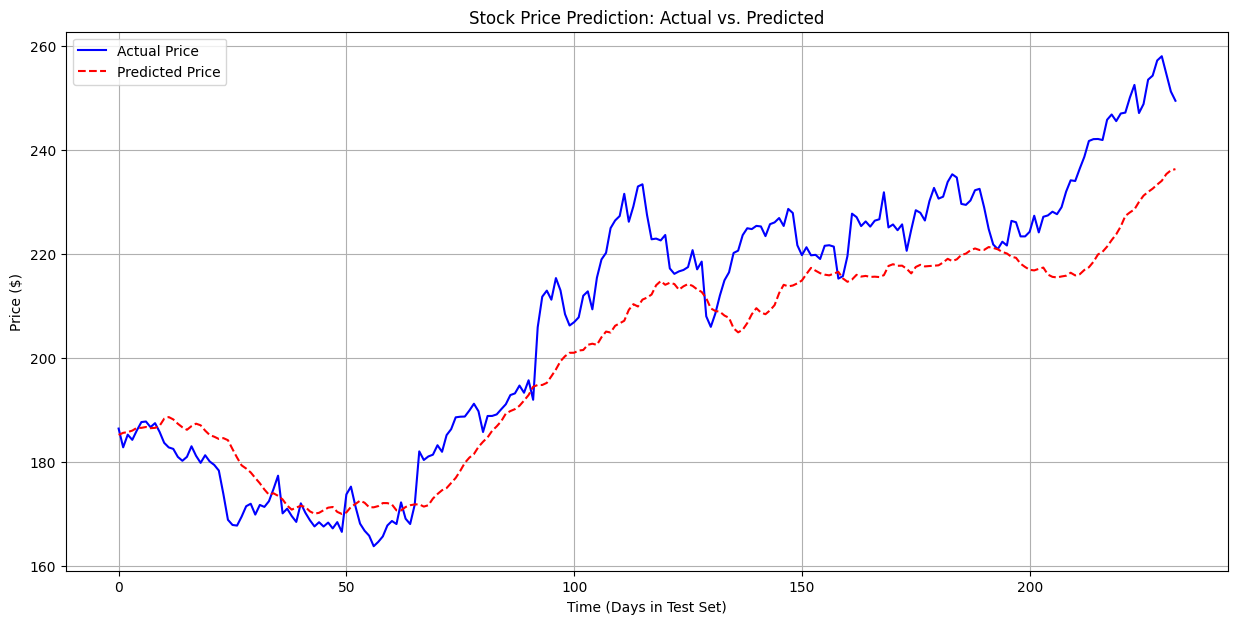

In [10]:
# =================================================================
# CELL 3: LOAD, EVALUATE, AND PREDICT
# =================================================================
try:
    # --- Load the saved model and scaler ---
    # The definition for TransformerEncoder is available from Cell 1
    print("--- Loading saved artifacts for evaluation ---")
    loaded_model = tf.keras.models.load_model('stock_prediction_transformer.keras')
    scaler = joblib.load('data_scaler.pkl')
    print("Model and scaler loaded successfully!")

    # --- Evaluation ---
    print("\n--- Evaluating Model Performance ---")
    # Make predictions on the entire test set
    predictions_scaled = loaded_model.predict(X_test)

    # We need to reshape the predictions to inverse_transform them
    # Create a dummy matrix that matches the shape the scaler expects
    dummy_matrix_pred = np.zeros((len(predictions_scaled), X_test.shape[2]))
    dummy_matrix_pred[:, 0] = predictions_scaled.flatten()
    predicted_prices = scaler.inverse_transform(dummy_matrix_pred)[:, 0]

    # Do the same for the actual prices for a fair comparison
    dummy_matrix_true = np.zeros((len(y_test), X_test.shape[2]))
    dummy_matrix_true[:, 0] = y_test.flatten()
    actual_prices = scaler.inverse_transform(dummy_matrix_true)[:, 0]

    # Calculate final MAE in dollars
    mae = np.mean(np.abs(predicted_prices - actual_prices))
    print(f"\nFinal Mean Absolute Error (MAE) on Test Data: ${mae:.2f}")

    # --- Plotting Results ---
    plt.figure(figsize=(15, 7))
    plt.plot(actual_prices, label='Actual Price', color='blue')
    plt.plot(predicted_prices, label='Predicted Price', color='red', linestyle='--')
    plt.title('Stock Price Prediction: Actual vs. Predicted')
    plt.xlabel('Time (Days in Test Set)')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print("\nERROR: Could not find 'stock_prediction_transformer.keras' or 'data_scaler.pkl'. Make sure Cell 2 ran successfully.")
except Exception as e:
    print(f"An unexpected error occurred during evaluation: {e}")
